In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import importlib

import time

In [2]:
import importlib
import os
import shutil
import torch
from glob import glob

In [3]:
import ptycho_torch.datagen.datagen
import ptycho_torch.datagen.probe
import ptycho_torch.datagen.objects
import ptycho_torch.dataloader
importlib.reload(ptycho_torch.datagen.datagen)
importlib.reload(ptycho_torch.datagen.probe)
importlib.reload(ptycho_torch.datagen.objects)
importlib.reload(ptycho_torch.dataloader)

from ptycho_torch.datagen.datagen import simulate_multiple_experiments, generate_simulated_data
from ptycho_torch.datagen.datagen import assemble_precomputed_images, simulate_synthetic_objects, simulate_synthetic_probes
from ptycho_torch.datagen.probe import generate_random_fzp, generate_random_zernike, generate_zernike_probe
from ptycho_torch.datagen.objects import generate_base_map_shapes_perlin_layers, create_complex_polyhedra, create_dead_leaves, create_white_noise_object, create_simplex_noise_object
from ptycho_torch.config_params import DataConfig, update_existing_config
from ptycho_torch.datagen.datagen import generate_data_from_experiment
from ptycho_torch.dataloader import PtychoDataset


In [4]:
def remove_all_files(directory_path):
    """
    Remove all files in the specified directory without removing the directory itself.
    
    Args:
        directory_path (str): Path to the directory whose files should be removed
        
    Returns:
        int: Number of files removed
    """
    count = 0
    
    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Directory '{directory_path}' does not exist.")
        return count
        
    # Loop through all items in the directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        
        # Check if it's a file and remove it
        if os.path.isfile(item_path):
            os.remove(item_path)
            count += 1
            
    print(f"Removed {count} files from '{directory_path}'")
    return count

In [ ]:
#Prep and setting up

#Calculating number of synthetic objects/probes needed
exp_dir_list = [#'../../data/pinn_cnm',
            # '../../data/pinn_fly001',
            # '../../data/pinn_als_ns',
            #'../../data/pinn_als_gold',
            # '../../data/pinn_gold_tp_1',
            # '../../data/pinn_gold_tp_2',
            '../../data/pinn_ic_1',
            # '../../data/pinn_ic_2',
            # '../../data/pinn_ncm',
            # '../../data/pinn_micro_lfp',
            # '../../data/pinn_als_ns',
            ]

probe_name_list = [item.split('/')[-1] for item in exp_dir_list]

n_exp_probes = len(exp_dir_list)
obj_per_exp_probe = 4

n_exp_obj = n_exp_probes * obj_per_exp_probe
n_synth_obj = 0 # Number of objects associated with synthetic probes

#Total number of "experiments" (i.e. number of synthetic objects needed)
#is number of experimental objects + number of synthetic objects
#Essentially, we want the experimental probes to get "more" objects per probe
n_experiments = n_exp_obj + n_synth_obj


#Image sizing
images_per_experiment = 7000
img_shape = (200,200) #Object sizing

#Misc
save_dir = "../../data/supervised_experiments"

#Probe arguments
probe_arg = {'ortho': True,
             'beamstop_diameter': 4,
             'phase_noise': True,
             'amp_noise': True,
             'max_order': 10,
             'probe_names': probe_name_list,}

            #  'probe_method': 'fzp'}

#Data configs
data_config = DataConfig()
data_config_replace = {'N': 64}
update_existing_config(data_config, data_config_replace)


# Generating experimental replicas for supervised learning version 

In [25]:
remove_all_files(save_dir)
for i, exp_dir in enumerate(exp_dir_list):

    
    exp_files = glob(os.path.join(exp_dir, '*.npz'))[0]
    dat_i = np.load(exp_files, allow_pickle=True)

    print(f"Processing experiment {i+1}/{len(exp_dir_list)}: {exp_files}")
    
    raw_data = generate_data_from_experiment(dat_i['diff3d'], dat_i['objectGuess'],
                                                    dat_i['probeGuess'], dat_i['xcoords'],
                                                    dat_i['ycoords'], data_config, probe_arg,
                                                    batch_size=500)

    # Save the simulation dictionary to a file
    save_dir_i = exp_dir+'_supervised'
    if not os.path.exists(save_dir_i):
        os.mkdir(save_dir_i)
    save_name = "supervised_" + exp_dir.split('/')[-1]
    save_path = save_dir_i + '/' + save_name

    np.savez(save_path,
                diff3d = raw_data['diff3d'],
                label = raw_data['label'],
                objectGuess = raw_data['objectGuess'],
                probeGuess = raw_data['probeGuess'].squeeze(),
                xcoords = raw_data['xcoords'],
                ycoords = raw_data['ycoords'],
                )


                                                    


Removed 0 files from '../../data/supervised_experiments'
Processing experiment 1/10: ../../data/pinn_cnm/CNM_APS_XNP_scan39_pty-chi_LSQML-64.npz
Beginning extraction...
Processing 25921 images in batches of 500...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  Getting image patches...
  G

## Testing dataset with this

In [7]:
from ptycho_torch.config_params import DataConfig, ModelConfig, TrainingConfig
from ptycho_torch.dataloader import PtychoDataset, TensorDictDataLoader, Collate

In [ ]:
#Define directory paths
#All experiment npz files are separate files in the ptycho_dir
#All probe npz files are separate files in the probe_dir
ptycho_dir = "../../data/supervised_synthetic"

# #Modify specific settings here
data_config = DataConfig()
model_config = ModelConfig()
training_config = TrainingConfig()

data_config_replace = {'N': 64,
                        'normalize': True,
                        'n_subsample': 1,
                        'C': 1}

model_config_replace = {'mode': 'Supervised',
                        "loss_function": "MAE",
                        "decoder_last_c_outer_fraction": 0.125,
                        "decoder_last_amp_channels": 1,
                        "cbam_encoder": True}


# #Update settings
update_existing_config(data_config, data_config_replace)
update_existing_config(model_config, model_config_replace)

# data_config.x_bounds = (0.05,0.95)
# data_config.y_bounds = (0.05,0.95)


#Creating dataset
print('Creating dataset...')
ptycho_dataset = PtychoDataset(ptycho_dir, model_config, data_config,
                                remake_map=True)

#Dataloader
print('Creating dataloader...')
train_loader = TensorDictDataLoader(ptycho_dataset, batch_size = 64,
                                    collate_fn = Collate(training_config.device))



Creating dataset...
Calculating dataset length with coordinate bounds...
For file ../../data/supervised_experiments/supervised_pinn_fly001.npz, maximum x_range is (33.484195709228516, 198.51580810546875), yrange is (33.05133819580078, 198.9486541748047)
Creating memory mapped tensor dictionary...
Memory map length: 6419
Memory map creation time: 0.0011942386627197266
Populating memory map for dataset 0
Start - end = 6419
Assigning labels...
Non-diffraction memory map write time: 2.1226789951324463
Getting normalization coefficients...
Normalizing constant: 0.006315514445304871
Diffraction memory map write time: 0.1191868782043457
[PtychoDataset Rank 0] Initialization successful. Dataset length: 6419.
Creating dataloader...


In [83]:
train_batch = next(iter(train_loader))

In [90]:
label_amp[0].squeeze().shape, diff[0].squeeze().shape

(torch.Size([64, 64]), torch.Size([64, 64]))

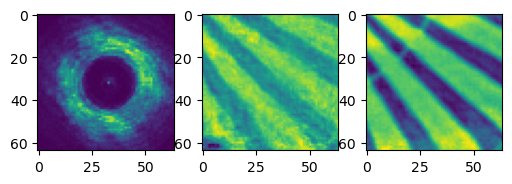

In [97]:
diff = train_batch[0]['images'].detach().cpu()
label_amp = train_batch[0]['label_amp'].detach().cpu()
label_phase = train_batch[0]['label_phase'].detach().cpu()

fig, axs = plt.subplots(1,3,figsize=(6,5))
idx = 3
axs[0].imshow(diff[idx].squeeze())
axs[1].imshow(label_amp[idx].squeeze())
axs[2].imshow(label_phase[idx].squeeze())

# Generating synthetic data

In [99]:
save_dir = "../../data/supervised_synthetic"
#Only do this if we need new data
save_bool = False

#Generating object list, probe list
synthetic_obj_list = simulate_synthetic_objects(img_shape, data_config, n_experiments, "dead_leaves")

synthetic_probe_list = simulate_synthetic_probes(data_config, n_synth_obj, "zernike",
                                                 probe_arg)

if save_bool:
    synth_save_dir = "../data/synthetic_data_fixed"
    save_name = synth_save_dir + "/" + "synthetic_data_"  
    for i in range(len(synthetic_probe_list)):
        save_name_i = save_name + str(i)
        np.savez(save_name_i,
            objectGuess = synthetic_obj_list[i],
            probeGuess = synthetic_probe_list[i])

Amplitude range: 0.6000 - 1.1000
Phase range: -3.1416 - 3.1416 radians
Beta map range: 0.0000e+00 - 9.9349e-04
Delta map range: 0.0000e+00 - 1.1076e-01
Amplitude range: 0.6000 - 1.1000
Phase range: -3.1416 - 3.1416 radians
Beta map range: 0.0000e+00 - 9.9887e-04
Delta map range: 0.0000e+00 - 1.1891e-01
Amplitude range: 0.6000 - 1.1000
Phase range: -3.1416 - 3.1416 radians
Beta map range: 0.0000e+00 - 9.9265e-04
Delta map range: 0.0000e+00 - 1.1095e-01
Amplitude range: 0.6000 - 1.1000
Phase range: -3.1416 - 3.1416 radians
Beta map range: 0.0000e+00 - 9.9932e-04
Delta map range: 0.0000e+00 - 1.1291e-01


In [100]:
#Only assemble experimental probes. Objects will be synthetic
exp_probe_list = assemble_precomputed_images(exp_dir_list, 'probe')
# exp_obj_list = assemble_precomputed_images(exp_dir_list, 'object')

#We'll give each probe 2 objects to train on
probe_list = [item for item in exp_probe_list for _ in range(obj_per_exp_probe)] \
              + synthetic_probe_list

#Assign probe name indices based on what index the item is in the probe list
probe_name_idx = [idx for idx in list(range(len(exp_dir_list))) for _ in range(obj_per_exp_probe)] \
                + [idx + n_exp_probes * obj_per_exp_probe for idx in range(len(synthetic_probe_list))]
                
probe_arg['probe_name_idx'] = probe_name_idx

#The rest will just be vanilla

#Remnove old files
remove_all_files(save_dir)

#Save new ones
simulate_multiple_experiments(synthetic_obj_list, probe_list,
                              images_per_experiment,
                              img_shape, data_config, probe_arg,
                              save_dir)

torch.cuda.empty_cache()

Removed 0 files from '../../data/supervised_synthetic'
----Beginning simulation for experiment 0----
Beginning simulation...
Processing 7000 images in batches of 3000...
  Getting image patches...
  Diffracting...
  Poisson scaling...
  Applying detector beamstop...
  Getting image patches...
  Diffracting...
  Poisson scaling...
  Applying detector beamstop...
  Getting image patches...
  Diffracting...
  Poisson scaling...
  Applying detector beamstop...
Concatenating results...
----Finished saving for experiment 0 in 0.8368055820465088 seconds----
----Beginning simulation for experiment 1----
Beginning simulation...
Processing 7000 images in batches of 3000...
  Getting image patches...
  Diffracting...
  Poisson scaling...
  Applying detector beamstop...
  Getting image patches...
  Diffracting...
  Poisson scaling...
  Applying detector beamstop...
  Getting image patches...
  Diffracting...
  Poisson scaling...
  Applying detector beamstop...
Concatenating results...
----Finished